### Analysing points of lucky escapes using FCD, OSM & Accident data For the city of Bremen

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import folium 
import seaborn as sns
import osmnx as ox
import networkx as nx
import pyproj
import math 
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import pysal 
from pysal import esda
#import libpysal #added
pd.options.mode.chained_assignment = None 
#from pysal.explore import esda
from pyproj import CRS
from pyproj import Transformer
from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

/opt/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
#Bremen Bounding box
bbox = BboxSelector([
    8.470458984375, # min_x
    52.884048623975254, # min_y
    9.16259765625, # max_x
    53.18464174858166  # max_y
])

#issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=100) # requesting 100 tracks inside the bbox
#display output
track_df

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,Speed.value,Speed.unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,...,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
0,5eec7ab5d6e3cf256ba40e9f,2020-06-18T19:25:52,POINT (8.80058 53.07321),5.500,%,0.0,km/h,57.000001,m,17.000000,...,169.580018,2020-06-18T19:25:52Z,2020-06-18T21:21:23Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
1,5eec7ab5d6e3cf256ba40ebd,2020-06-18T19:25:57,POINT (8.80058 53.07321),6.000,%,0.0,km/h,57.000002,m,17.000000,...,169.580018,2020-06-18T19:25:52Z,2020-06-18T21:21:23Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
2,5eec7ab5d6e3cf256ba40ec0,2020-06-18T19:26:02,POINT (8.80057 53.07321),4.000,%,3.0,km/h,56.999999,m,17.000000,...,169.580018,2020-06-18T19:25:52Z,2020-06-18T21:21:23Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
3,5eec7ab5d6e3cf256ba40ec1,2020-06-18T19:26:07,POINT (8.80058 53.07321),3.500,%,0.0,km/h,57.000002,m,17.000000,...,169.580018,2020-06-18T19:25:52Z,2020-06-18T21:21:23Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
4,5eec7ab5d6e3cf256ba40ec2,2020-06-18T19:26:12,POINT (8.80057 53.07321),3.325,%,0.0,km/h,56.999998,m,16.999999,...,169.580018,2020-06-18T19:25:52Z,2020-06-18T21:21:23Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,5e24ca2563c90936dc7b2fa1,2020-01-15T08:52:50,POINT (8.84802 53.10522),2.000,%,2.0,km/h,42.000001,m,15.135064,...,6.257810,2020-01-15T08:38:42Z,2020-01-15T08:53:10Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
169,5e24ca2563c90936dc7b2fa2,2020-01-15T08:52:55,POINT (8.84805 53.10522),2.000,%,0.0,km/h,42.000001,m,15.000000,...,6.257810,2020-01-15T08:38:42Z,2020-01-15T08:53:10Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
170,5e24ca2563c90936dc7b2fa3,2020-01-15T08:53:00,POINT (8.84805 53.10522),2.000,%,0.0,km/h,42.000000,m,15.000000,...,6.257810,2020-01-15T08:38:42Z,2020-01-15T08:53:10Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge
171,5e24ca2563c90936dc7b2fa4,2020-01-15T08:53:05,POINT (8.84805 53.10522),2.000,%,0.0,km/h,42.000000,m,15.000000,...,6.257810,2020-01-15T08:38:42Z,2020-01-15T08:53:10Z,car,1798,Caliber,58395f40e4b0a979d45bd61b,gasoline,2007,Dodge


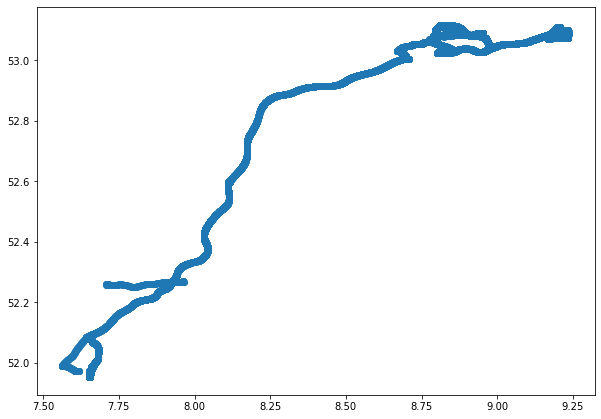

In [3]:
#Track plot
track_df.plot(figsize=(10, 12))

In [4]:
#dataframe details
track_df.describe()

,GPS Accuracy.value,Speed.value,GPS Altitude.value,Throttle Position.value,GPS VDOP.value,GPS HDOP.value,GPS Speed.value,Intake Temperature.value,GPS Bearing.value,Consumption.value,Engine Load.value,GPS PDOP.value,Calculated MAF.value,CO2.value,Intake Pressure.value,Rpm.value,track.length,sensor.engineDisplacement,sensor.constructionYear
count,38761.000000,38664.000000,38761.000000,38662.000000,38760.000000,38760.000000,38761.000000,38662.000000,38761.000000,38660.000000,38661.000000,38760.000000,38660.000000,38660.000000,38663.000000,38662.000000,38761.000000,38761.0,38761.0
mean,1.666819,76.923317,60.296755,21.733883,0.803378,0.480799,77.565099,16.502236,152.916011,7.063293,49.438388,0.985656,21.487125,16.598738,58.235089,2236.497659,68.259238,1798.0,2007.0
std,0.886052,44.717796,22.596868,8.742719,0.250415,0.171822,45.397826,7.522750,104.318562,4.472717,21.175912,0.288772,13.606377,10.510884,19.605765,943.148531,55.604793,0.0,0.0
min,0.255624,0.000000,13.000000,8.115151,0.600000,0.306535,0.000000,3.000000,0.000000,-1.090800,-495.792866,0.800000,-3.318304,-2.563380,16.000000,-183.913050,0.410732,1798.0,2007.0
25%,1.301404,42.999999,47.000000,16.000000,0.653426,0.400000,42.834051,10.000000,57.697065,2.581493,33.454833,0.800000,7.853118,6.066509,43.033047,1469.804288,37.591220,1798.0,2007.0
50%,1.500000,78.383431,53.000000,20.000000,0.800000,0.400000,79.189595,16.000000,152.183873,6.269403,47.843136,1.000000,19.072046,14.733097,59.956954,2128.999984,43.572308,1798.0,2007.0
75%,2.000000,119.000001,61.999998,25.000000,0.800000,0.600000,120.431850,22.000000,239.899993,10.918803,63.382507,1.000000,33.215909,25.659188,71.741450,3148.663003,62.720093,1798.0,2007.0
max,45.000000,373.333340,195.999997,89.000003,10.800000,5.560080,174.567824,44.000001,359.892290,23.693925,100.000003,11.000000,72.078894,55.680724,123.689759,4530.827519,170.988195,1798.0,2007.0


In [5]:
#sorting by the track id
track_df.groupby(track_df['track.id']).count()

,id,time,geometry,GPS Accuracy.value,GPS Accuracy.unit,Speed.value,Speed.unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,...,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
track.id,,,,,,,,,,,,,,,,,,,,,
5e24ca2463c90936dc7b2ef6,173,173,173,173,173,172,172,173,173,172,...,173,173,173,173,173,173,173,173,173,173
5e24ca2563c90936dc7b3019,146,146,146,146,146,145,145,146,146,145,...,146,146,146,146,146,146,146,146,146,146
5e24ca2663c90936dc7b34d8,272,272,272,272,272,271,271,272,272,271,...,272,272,272,272,272,272,272,272,272,272
5e24ca2663c90936dc7b380c,343,343,343,343,343,342,342,343,343,342,...,343,343,343,343,343,343,343,343,343,343
5e24ca2763c90936dc7b3c15,595,595,595,595,595,594,594,595,595,594,...,595,595,595,595,595,595,595,595,595,595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5eec7aa9d6e3cf256ba3f57a,277,277,277,277,277,276,276,277,277,276,...,277,277,277,277,277,277,277,277,277,277
5eec7aadd6e3cf256ba3fea3,452,452,452,452,452,451,451,452,452,451,...,452,452,452,452,452,452,452,452,452,452
5eec7aafd6e3cf256ba403f3,472,472,472,472,472,471,471,472,472,471,...,472,472,472,472,472,472,472,472,472,472


,id,track.id,time,lat,lng,speed,year,month,spddiff
0,5eec7ab5d6e3cf256ba40e9f,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:25:52,53.073211,8.800575,0.000000,2020,6,0.000000
1,5eec7ab5d6e3cf256ba40ebd,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:25:57,53.073212,8.800575,0.000000,2020,6,0.000000
2,5eec7ab5d6e3cf256ba40ec0,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:02,53.073209,8.800575,0.000000,2020,6,0.000000
3,5eec7ab5d6e3cf256ba40ec1,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:07,53.073212,8.800575,0.000000,2020,6,0.000000
4,5eec7ab5d6e3cf256ba40ec2,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:12,53.073209,8.800575,0.000000,2020,6,0.000000
...,...,...,...,...,...,...,...,...,...
168,5e24ca2563c90936dc7b2fa1,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:50,53.105221,8.848018,2.897163,2020,1,2.423636
169,5e24ca2563c90936dc7b2fa2,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:55,53.105223,8.848054,0.000000,2020,1,-2.897163
170,5e24ca2563c90936dc7b2fa3,5e24ca2463c90936dc7b2ef6,2020-01-15T08:53:00,53.105222,8.848054,0.000000,2020,1,0.000000
171,5e24ca2563c90936dc7b2fa4,5e24ca2463c90936dc7b2ef6,2020-01-15T08:53:05,53.105222,8.848054,0.000000,2020,1,0.000000


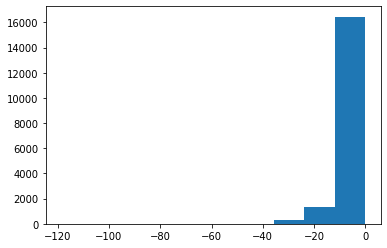

In [6]:
#Calculating the speed difference at points
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
track_df['speed'] = track_df['GPS Speed.value']
track_df['time_year'] = pd.to_datetime(track_df['time'], format = "%Y-%m")
track_df['year'] = track_df['time_year'].dt.year
track_df['month'] = track_df['time_year'].dt.month

data_to_export = track_df[['id','track.id','time','lat','lng','speed','year','month']]
speed = data_to_export['speed']

spd_list = []
index = 0
for cal in speed:
    currspd = cal
    if index > 0:
        diff = currspd - prvspd
        spd_list.append(diff)
    else:
        spd_list.append(0)
    prvspd = currspd
    index += 1


data_to_export['spddiff']= spd_list
spdneg = data_to_export[data_to_export['spddiff']<0]

plt.hist(spdneg['spddiff'])
            
data_to_export

In [7]:
#mean reduction on speed on track
np.mean(spdneg['spddiff'])

-4.080480764530786

In [26]:
#making a function to color based on speed difference
def colors(array):
    col = []
    for value in array:
        if value < 0 and value > -5:
            col.append('yellow')
        elif value < -5 and value > -20:
            col.append('green')
        else:
            col.append('red')
    return col

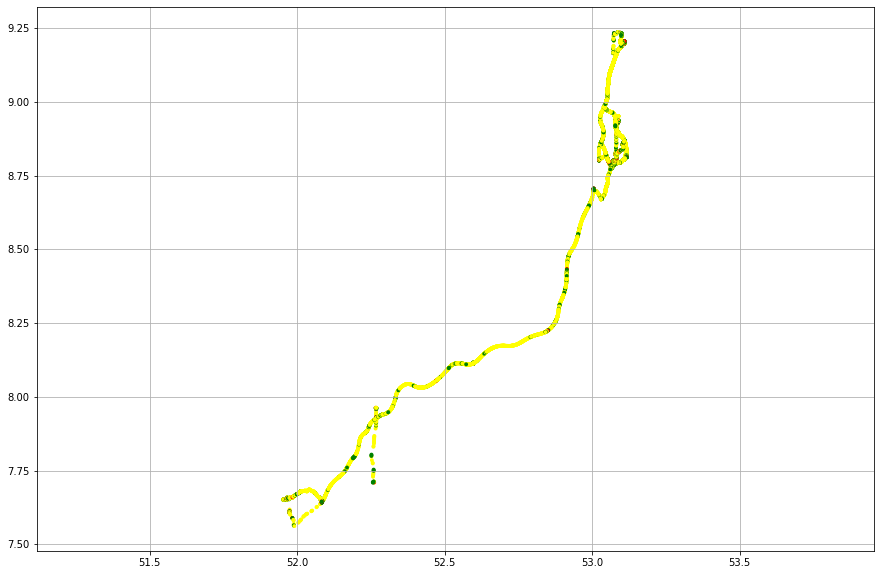

In [27]:
#plotting the tracks based on the reduction in speed
cols = colors(spdneg['spddiff'])
f,axxarr = plt.subplots(1, figsize = (15,10))   
axxarr.scatter(spdneg['lat'], spdneg['lng'], c=cols, cmap='Accent', s=15, lw=0)

plt.axis('equal')
axxarr.grid(True)
plt.show()

In [28]:
#choosing a single track
neg_data = data_to_export[data_to_export['spddiff'] < 0]
neg_data

,id,track.id,time,lat,lng,speed,year,month,spddiff
8,5eec7ab5d6e3cf256ba40ec8,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:33,53.073040,8.799917,18.133126,2020,6,-0.994582
9,5eec7ab5d6e3cf256ba40ecb,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:38,53.072975,8.799763,2.319662,2020,6,-15.813464
16,5eec7ab5d6e3cf256ba40ed6,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:13,53.073902,8.796026,41.507465,2020,6,-3.435670
17,5eec7ab5d6e3cf256ba40ed7,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:18,53.074108,8.795319,32.962743,2020,6,-8.544721
18,5eec7ab5d6e3cf256ba40ed8,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:23,53.074237,8.794798,17.715468,2020,6,-15.247276
...,...,...,...,...,...,...,...,...,...
162,5e24ca2563c90936dc7b2f9b,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:20,53.105415,8.848268,11.245667,2020,1,-1.492507
164,5e24ca2563c90936dc7b2f9d,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:30,53.105220,8.848038,8.064000,2020,1,-3.439606
165,5e24ca2563c90936dc7b2f9e,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:35,53.105194,8.847989,1.207713,2020,1,-6.856288
166,5e24ca2563c90936dc7b2f9f,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:40,53.105196,8.848000,0.000000,2020,1,-1.207713


In [29]:
#identify first record in each track and adding a default value of 0
tracks_id = (neg_data['id'].groupby(neg_data['track.id']).nth(0)).tolist()
neg_data['spddiff'][neg_data['id'].isin(tracks_id)] = 0

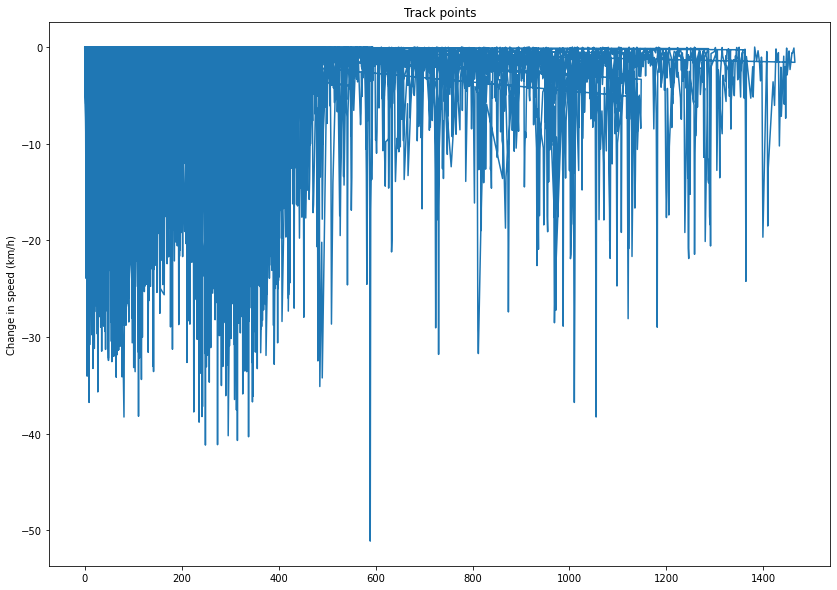

In [30]:
#plotting the change in speed
ax = neg_data['spddiff'].plot(figsize= (14, 10))
ax.set_title("Track points")
ax.set_ylabel("Change in speed (km/h)")
ax        

In [32]:
cols_some = colors(neg_data['spddiff'])
print(len(cols_some))
cols_some.pop()
len(cols_some)

18074


18073

In [15]:
#plotting points on a map using folium
lats = list(neg_data['lat'])
lngs = list(neg_data['lng'])
speed = list(neg_data['spddiff']) 
speedactual = list(neg_data['speed'])
avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
def popfn(popa, popb):
    return('Speed Difference is: '+ str(round(popa, 2))+ 'Km/h'+'\n Actual speed is:' + str(round(popb, 2))+'Km/h')

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=8)
for lat, lng , col, pop,pop1 in zip(lats,lngs, cols_some, speed, speedactual ):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = popfn(pop, pop1)).add_to(m)
m.save('negspeeddiffbremen.html')

## Downloading OSM Data for Bremen

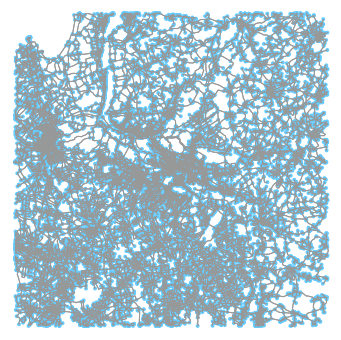

(<Figure size 721.736x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3f611450>)

In [16]:
#downloading road netwrok from osmnx
G = ox.graph_from_point((53.07, 8.80), dist=50000, network_type='drive')
ox.plot_graph(G)

In [17]:
#exploring the data frame
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.columns

Index(['u', 'v', 'key', 'osmid', 'lanes', 'name', 'highway', 'maxspeed',
       'oneway', 'length', 'geometry', 'ref', 'bridge', 'access', 'width',
       'tunnel', 'junction', 'area', 'est_width', 'service'],
      dtype='object')

In [18]:
edges['geometry'].dtype

In [19]:
edges['geometry']

0         LINESTRING (8.94994 53.16049, 8.94962 53.16054...
1         LINESTRING (8.23092 53.06157, 8.23063 53.06133...
2         LINESTRING (8.23092 53.06157, 8.23173 53.06225...
3         LINESTRING (8.23092 53.06157, 8.23052 53.06175...
4         LINESTRING (8.23092 53.06157, 8.23216 53.06102...
                                ...                        
173803    LINESTRING (8.16735 52.83781, 8.16751 52.83784...
173804      LINESTRING (8.45178 53.39675, 8.45190 53.39702)
173805    LINESTRING (8.45178 53.39675, 8.45158 53.39634...
173806    LINESTRING (8.45178 53.39675, 8.45135 53.39682...
173807    LINESTRING (8.92952 53.15308, 8.92989 53.15330...
Name: geometry, Length: 173808, dtype: geometry

In [21]:
print(edges['maxspeed'].value_counts())

30                49496
50                29373
100                4030
70                 3626
[100, 50]           891
                  ...  
[30, 60]              1
[60, 30]              1
[80, none]            1
[30, 50, none]        1
[120, 40]             1
Name: maxspeed, Length: 100, dtype: int64


In [22]:
print(edges['highway'].value_counts())

residential                       96226
unclassified                      24695
tertiary                          17536
living_street                     13300
secondary                         12699
primary                            4392
[unclassified, residential]        1575
motorway_link                      1158
[living_street, residential]        450
motorway                            414
trunk_link                          336
trunk                               255
primary_link                        226
road                                170
secondary_link                       86
tertiary_link                        84
[unclassified, living_street]        40
rest_area                            36
[tertiary, residential]              22
virtual                              18
[unclassified, tertiary]             16
[trunk, primary]                     15
crossing                             12
[residential, road]                   8
[motorway, motorway_link]             4


In [24]:
edges.head()

,u,v,key,osmid,lanes,name,highway,maxspeed,oneway,length,geometry,ref,bridge,access,width,tunnel,junction,area,est_width,service
0,5520752640,31119067,0,575304707,2,Heinz-Lemmermann-Weg,residential,50,False,231.220,"LINESTRING (8.94994 53.16049, 8.94962 53.16054...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83623940,83623949,0,24586723,2,NaN,motorway_link,NaN,False,93.728,"LINESTRING (8.23092 53.06157, 8.23063 53.06133...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83623940,267281976,0,25671346,NaN,Streeker Trift,unclassified,70,False,1316.621,"LINESTRING (8.23092 53.06157, 8.23173 53.06225...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83623940,85675471,0,171077758,NaN,Bümmersteder Straße,tertiary,70,False,437.113,"LINESTRING (8.23092 53.06157, 8.23052 53.06175...",K 346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83623940,330342598,0,"[182897080, 24586707, 171077758]",NaN,Bümmersteder Straße,tertiary,70,False,230.007,"LINESTRING (8.23092 53.06157, 8.23216 53.06102...",K 346,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#reprojecting the OSM data to projected crs and applying a buffer
prjedge = edges.to_crs('EPSG:25832')
prjedge['geometry'] = prjedge.geometry.buffer(5)
prjedge.head()

,u,v,key,osmid,lanes,name,highway,maxspeed,oneway,length,geometry,ref,bridge,access,width,tunnel,junction,area,est_width,service
0,5520752640,31119067,0,575304707,2,Heinz-Lemmermann-Weg,residential,50,False,231.220,"POLYGON ((496630.287 5890125.667, 496629.794 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83623940,83623949,0,24586723,2,NaN,motorway_link,NaN,False,93.728,"POLYGON ((448444.987 5879366.516, 448436.645 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83623940,267281976,0,25671346,NaN,Streeker Trift,unclassified,70,False,1316.621,"POLYGON ((448511.503 5879473.478, 448551.172 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83623940,85675471,0,171077758,NaN,Bümmersteder Straße,tertiary,70,False,437.113,"POLYGON ((448431.018 5879412.165, 448430.945 5...",K 346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83623940,330342598,0,"[182897080, 24586707, 171077758]",NaN,Bümmersteder Straße,tertiary,70,False,230.007,"POLYGON ((448545.869 5879337.775, 448546.185 5...",K 346,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Converting the negative data to a dataframe and reprojecting to a projected CRS
some_trk = gpd.GeoDataFrame(
    neg_data, geometry=gpd.points_from_xy(neg_data.lng, neg_data.lat),crs="EPSG:4326")
#some_trk.crs = "EPSG:4326"
some_trk_tr = some_trk.to_crs('EPSG:25832')
some_trk_tr

,id,track.id,time,lat,lng,speed,year,month,spddiff,geometry
8,5eec7ab5d6e3cf256ba40ec8,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:33,53.073040,8.799917,18.133126,2020,6,0.000000,POINT (486595.043 5880414.343)
9,5eec7ab5d6e3cf256ba40ecb,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:26:38,53.072975,8.799763,2.319662,2020,6,-15.813464,POINT (486584.722 5880407.132)
16,5eec7ab5d6e3cf256ba40ed6,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:13,53.073902,8.796026,41.507465,2020,6,-3.435670,POINT (486334.645 5880511.062)
17,5eec7ab5d6e3cf256ba40ed7,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:18,53.074108,8.795319,32.962743,2020,6,-8.544721,POINT (486287.291 5880534.014)
18,5eec7ab5d6e3cf256ba40ed8,5eec7ab5d6e3cf256ba40e8d,2020-06-18T19:27:23,53.074237,8.794798,17.715468,2020,6,-15.247276,POINT (486252.451 5880548.560)
...,...,...,...,...,...,...,...,...,...,...
162,5e24ca2563c90936dc7b2f9b,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:20,53.105415,8.848268,11.245667,2020,1,-1.492507,POINT (489842.040 5884007.931)
164,5e24ca2563c90936dc7b2f9d,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:30,53.105220,8.848038,8.064000,2020,1,-3.439606,POINT (489826.564 5883986.324)
165,5e24ca2563c90936dc7b2f9e,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:35,53.105194,8.847989,1.207713,2020,1,-6.856288,POINT (489823.312 5883983.435)
166,5e24ca2563c90936dc7b2f9f,5e24ca2463c90936dc7b2ef6,2020-01-15T08:52:40,53.105196,8.848000,0.000000,2020,1,-1.207713,POINT (489824.048 5883983.651)


In [27]:
#Joinig negative data from FCD with the OSM data
join = gpd.sjoin(some_trk_tr, prjedge, op='intersects')
len(join)

17023

In [28]:
join['maxspeed'].count

<bound method Series.count of 8       30
9       30
262     30
8       30
9       30
      ... 
128     50
107     50
108     50
108     30
108    NaN
Name: maxspeed, Length: 17023, dtype: object>

In [ ]:
#Sorting to get the minimum speed limit on roads with more than one speed limit 
def getMin(inp):
    min = 10000
    for i in inp:
        if i < min:
            min = i
    return min
        

In [29]:
#Sorting the speed limits 
speed_lst = []
for m in join['maxspeed']:
     #print(m,type(m))
    if (type(m) ==str and len(m) <= 3):
        speed_lst.append(int(m))
    elif type(m) == list:
        conv = []
        for n in m:
            try:
                conv.append(int(n))
            except ValueError:
                conv.append(130)
        speed_lst.append(getMin(conv))        
        
    else:
        speed_lst.append(130)
            
print(speed_lst)   

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,

In [31]:
#Removing columns that are not needed
join['spdlimit'] = speed_lst
df = join[['track.id', 'lat', 'lng', 'speed', 'spddiff', 'geometry', 'spdlimit','year', 'month']]
df

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month
8,5eec7ab5d6e3cf256ba40e8d,53.073040,8.799917,18.133126,0.000000,POINT (486595.043 5880414.343),30,2020,6
9,5eec7ab5d6e3cf256ba40e8d,53.072975,8.799763,2.319662,-15.813464,POINT (486584.722 5880407.132),30,2020,6
262,5eec7aa9d6e3cf256ba3f57a,53.073271,8.800293,2.490317,-3.342976,POINT (486620.313 5880440.026),30,2020,6
8,5eec7aafd6e3cf256ba403f3,53.073056,8.799881,14.579675,-1.885194,POINT (486592.596 5880416.158),30,2020,6
9,5eec7aafd6e3cf256ba403f3,53.072987,8.799718,7.559892,-7.019782,POINT (486581.715 5880408.475),30,2020,6
...,...,...,...,...,...,...,...,...,...
128,5e24ca2563c90936dc7b3019,53.106555,8.845600,18.645000,-11.871470,POINT (489663.722 5884135.128),50,2020,1
107,5e24ca2463c90936dc7b2ef6,53.089165,8.829423,54.714622,-2.744830,POINT (488576.118 5882203.094),50,2020,1
108,5e24ca2463c90936dc7b2ef6,53.089782,8.829881,53.775601,-0.939020,POINT (488606.926 5882271.669),50,2020,1
108,5e24ca2463c90936dc7b2ef6,53.089782,8.829881,53.775601,-0.939020,POINT (488606.926 5882271.669),30,2020,1


In [32]:
#Getting the speed above the limit 
df['ovrspd'] = df['speed']-df['spdlimit']
df[df['ovrspd'] > 5]

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd
67,5eec7ab5d6e3cf256ba40e8d,53.070435,8.781658,69.799840,-1.461526,POINT (485370.827 5880128.131),60,2020,6,9.799840
70,5eec7ab5d6e3cf256ba40e8d,53.068209,8.779239,66.619274,-5.195072,POINT (485207.989 5879881.028),60,2020,6,6.619274
59,5ee49ea0d6e3cf256b64f463,53.070076,8.781116,69.480870,-0.807283,POINT (485334.427 5880088.320),60,2020,6,9.480870
61,5ee49ea0d6e3cf256b64f463,53.068597,8.779550,68.239382,-1.730730,POINT (485228.961 5879924.181),60,2020,6,8.239382
62,5ee49ea0d6e3cf256b64f463,53.067849,8.778869,67.113009,-1.126372,POINT (485183.115 5879841.065),60,2020,6,7.113009
...,...,...,...,...,...,...,...,...,...,...
113,5e24ca2563c90936dc7b3019,53.113416,8.845467,70.687174,-4.451984,POINT (489656.421 5884898.434),50,2020,1,20.687174
114,5e24ca2563c90936dc7b3019,53.113042,8.846702,62.494047,-8.193128,POINT (489739.019 5884856.590),50,2020,1,12.494047
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179


In [33]:
df.to_crs('EPSG:4326')

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year,month,ovrspd
8,5eec7ab5d6e3cf256ba40e8d,53.073040,8.799917,18.133126,0.000000,POINT (8.79992 53.07304),30,2020,6,-11.866874
9,5eec7ab5d6e3cf256ba40e8d,53.072975,8.799763,2.319662,-15.813464,POINT (8.79976 53.07297),30,2020,6,-27.680338
262,5eec7aa9d6e3cf256ba3f57a,53.073271,8.800293,2.490317,-3.342976,POINT (8.80029 53.07327),30,2020,6,-27.509683
8,5eec7aafd6e3cf256ba403f3,53.073056,8.799881,14.579675,-1.885194,POINT (8.79988 53.07306),30,2020,6,-15.420325
9,5eec7aafd6e3cf256ba403f3,53.072987,8.799718,7.559892,-7.019782,POINT (8.79972 53.07299),30,2020,6,-22.440108
...,...,...,...,...,...,...,...,...,...,...
128,5e24ca2563c90936dc7b3019,53.106555,8.845600,18.645000,-11.871470,POINT (8.84560 53.10655),50,2020,1,-31.355000
107,5e24ca2463c90936dc7b2ef6,53.089165,8.829423,54.714622,-2.744830,POINT (8.82942 53.08917),50,2020,1,4.714622
108,5e24ca2463c90936dc7b2ef6,53.089782,8.829881,53.775601,-0.939020,POINT (8.82988 53.08978),50,2020,1,3.775601
108,5e24ca2463c90936dc7b2ef6,53.089782,8.829881,53.775601,-0.939020,POINT (8.82988 53.08978),30,2020,1,23.775601


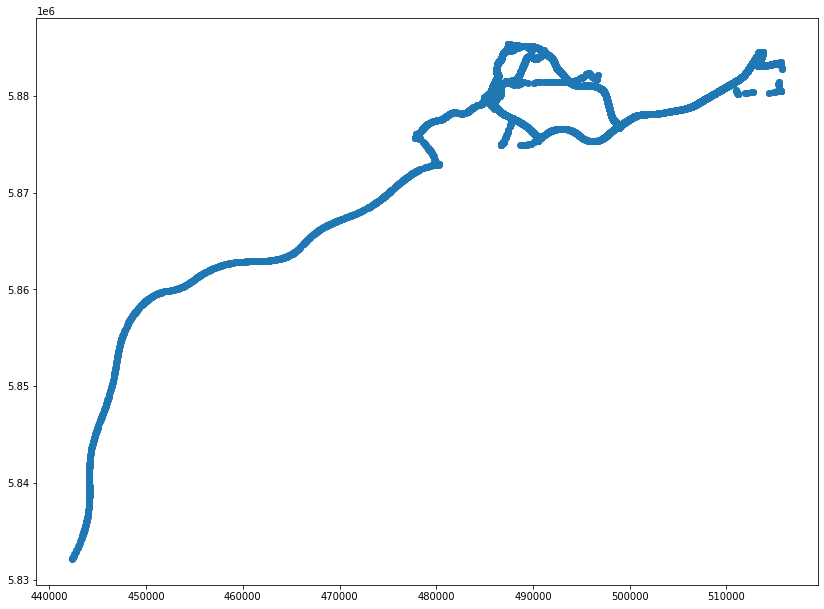

In [34]:
df.plot(figsize = (14,14))

In [35]:
#reading the accident data from CSV
acc = pd.read_csv('Bremen_modified.csv', usecols=['year','month','hour', 'day_of_week', 'accident_category','longitude', 'latitude'])
acc

,month,year,hour,accident_category,longitude,latitude,day_of_week
0,8,15,18,5.0,8.737263,53.143835,5
1,9,15,14,3.0,8.914209,53.038981,3
2,8,15,14,5.0,8.780575,53.068084,7
3,8,15,9,3.0,8.778113,53.064216,5
4,8,15,13,3.0,8.783901,53.065758,5
...,...,...,...,...,...,...,...
34770,6,18,17,5.0,8.749113,53.160368,5
34771,9,18,13,5.0,8.894172,53.059490,2
34772,8,17,9,3.0,8.891053,53.071478,3
34773,12,16,9,3.0,8.818448,53.077264,2


In [97]:
#Making a geodataframe of the acident data 
gdf = gpd.GeoDataFrame(
    acc, geometry=gpd.points_from_xy(acc.longitude, acc.latitude),crs="EPSG:4326")

In [98]:
gdf_cat = gdf.groupby(['longitude','latitude'])[['accident_category']].mean().reset_index()
gdf_cat.head()

,longitude,latitude,accident_category
0,8.508739,53.221201,3.0
1,8.508849,53.220920,5.0
2,8.508863,53.220912,5.0
3,8.509131,53.220115,5.0
4,8.509141,53.220104,5.0


In [38]:
#function to define the color bands
def clr(array):
    col = []
    for value in array:
        if value > 0: 
            col.append('red')
        else:
            col.append('#C2FF00')
    return col

In [39]:
#function to reproject coordinates
inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)

In [40]:
#Using the GetisOrd function to generate accident hot spots & cold spots
def getisOrd(data, value = 'value', threshold = 100, lat = 'lat', lng = 'lng'):
    coords = [project(row[lat], row[lng]) for index, row in data.iterrows()]
    w = pysal.weights.DistanceBand(coords, threshold)         #w = pysal.weights.DistanceBand(coords, threshold)
    #getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
    getisOrdLocal = esda.getisord.G_Local(data[value], w, transform='B')
    getisOrdLocal.Zs

    data['z_score'] = getisOrdLocal.Zs
    data['p_value'] = getisOrdLocal.p_norm

    return data

In [41]:
#Defining colors for the spots
def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('black')        #hotspot color
                size.append(3)
            else:
                cols.append('blue')       #coldspot color
                size.append(1)
        else:
            cols.append('grey')           #others
            size.append(0.5)
    return cols , size

In [42]:
#Map function
def map(m, data, value = 'value', style = 'hotspots', lat = 'lat', lng = 'lng', p_field = 'p_value', z_field = 'z_score', col ='#f09205'):
    data = data[data[p_field] < 0.05]
    lats = data[lat]
    lngs = data[lng]

    avg_lat = sum(lats) / len(lats)
    avg_lngs = sum(lngs) / len(lngs)

    latlngs = []
    if style == 'hotspots':
        #z-value
        z = data[z_field]
        p = data[p_field]
        color, sizes = pltcolor(p, z, 0.05)
        value = data[value]
        for lat,lng,c,v, s in zip(lats, lngs, color, value, sizes):
            folium.CircleMarker([lat,lng], color = c, radius =s, fill = c).add_to(m)
            latlngs.append([lat,lng])
    else:
        color = [col]*len(data)
        for lat,lng,c,s in zip(lats, lngs, color, sizes):
            folium.CircleMarker([lat,lng], color = c, radius =s, fill = c).add_to(m)
            latlngs.append([lat,lng])

    m.fit_bounds(latlngs)

In [43]:
#plotting the points of overspeeding and hot spots of accident
lats = list(df['lat'])
lngs = list(df['lng'])
speed = list(df['ovrspd']) 
spdlmt = list(df['spdlimit'])
def poplt(a,b):
    return('Speed limit is: '+ str(a) +'Km/h' +'\n above limit by:' + str(round(b, 2))+ 'Km/h')

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)
ovrspdclr = clr(df['ovrspd'])
m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=12)
for lat, lng , col, pop, pop1 in zip(lats,lngs, ovrspdclr, spdlmt, speed):
    folium.CircleMarker([lat, lng], color= col , radius=2.0, popup = poplt(pop, pop1)).add_to(m)
getisacc = getisOrd(gdf_cat, value='accident_category', threshold=150, lat='latitude', lng= 'longitude')
map(m, getisacc, value = 'accident_category', style ='hotspots', lat='latitude', lng= 'longitude')
m.save('hotspotbremen.html')

/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 48 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/opt/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 21, 23, 740, 1086, 1171, 1190, 1222, 2505, 2579, 2614, 2654, 2762, 3820, 4419, 4461, 4485, 4493, 4763, 4794, 4838, 4857, 4865, 5392, 5570, 5815, 5979, 6071, 6078, 6108, 6272, 6405, 6546, 7158, 14005, 15735, 19359, 22475, 23515, 26602, 28787, 29047, 29365, 31841, 32246, 33176, 33242, 34219, 34223
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))
/opt/anaconda3/lib/python3.7/site-packages/pysal/esda/getisord.py:434: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)


In [44]:
#reprojecting CRS to projected and buffering by 100m
acc_cd = gdf.to_crs('EPSG:25832')
acc_cd['geometry'] = acc_cd.geometry.buffer(100)

In [46]:
acc_cd

,month,year,hour,accident_category,longitude,latitude,day_of_week,geometry
0,8,15,18,5.0,8.737263,53.143835,5,"POLYGON ((482526.293 5888303.420, 482525.812 5..."
1,9,15,14,3.0,8.914209,53.038981,3,"POLYGON ((494347.722 5876610.298, 494347.240 5..."
2,8,15,14,5.0,8.780575,53.068084,7,"POLYGON ((485397.492 5879866.859, 485397.010 5..."
3,8,15,9,3.0,8.778113,53.064216,5,"POLYGON ((485231.194 5879437.080, 485230.713 5..."
4,8,15,13,3.0,8.783901,53.065758,5,"POLYGON ((485619.569 5879607.398, 485619.087 5..."
...,...,...,...,...,...,...,...,...
34770,6,18,17,5.0,8.749113,53.160368,5,"POLYGON ((483325.348 5890139.780, 483324.867 5..."
34771,9,18,13,5.0,8.894172,53.059490,2,"POLYGON ((493007.611 5878893.568, 493007.129 5..."
34772,8,17,9,3.0,8.891053,53.071478,3,"POLYGON ((492800.608 5880227.461, 492800.127 5..."
34773,12,16,9,3.0,8.818448,53.077264,2,"POLYGON ((487937.745 5880880.971, 487937.264 5..."


In [47]:
#Joining FCD with Accident data based on where points intersect in 100m radius
ovrspdacc = gpd.sjoin(df, acc_cd,op='intersects')
len(ovrspdacc)

401204

In [48]:
ovrspdacc
ovrspdacc.groupby(ovrspdacc['track.id']).count()

,lat,lng,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,index_right,month_right,year_right,hour,accident_category,longitude,latitude,day_of_week
track.id,,,,,,,,,,,,,,,,,
5e24ca2463c90936dc7b2ef6,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767,6767
5e24ca2563c90936dc7b3019,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753,4753
5e24ca2663c90936dc7b34d8,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223,6223
5e24ca2663c90936dc7b380c,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470
5e24ca2763c90936dc7b3c15,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396,12396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5eec7aa9d6e3cf256ba3f57a,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491,6491
5eec7aadd6e3cf256ba3fea3,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146,4146
5eec7aafd6e3cf256ba403f3,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223,4223


In [49]:
#points which FCD track is above speed limit by more than 5Km/h
ovrspd_acc = ovrspdacc[ovrspdacc['ovrspd']>5]
ovrspd_acc

,track.id,lat,lng,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,index_right,month_right,year_right,hour,accident_category,longitude,latitude,day_of_week
40,5eb99e7365b80c5d6be93126,53.072805,8.799668,35.227627,-0.311142,POINT (486578.305 5880388.285),30,2020,5,5.227627,5877,2,16,22,5.0,8.800437,53.072245,7
40,5eb99e7365b80c5d6be93126,53.072805,8.799668,35.227627,-0.311142,POINT (486578.305 5880388.285),30,2020,5,5.227627,14628,2,18,21,5.0,8.800373,53.072259,2
40,5eb99e7365b80c5d6be93126,53.072805,8.799668,35.227627,-0.311142,POINT (486578.305 5880388.285),30,2020,5,5.227627,28400,2,18,15,5.0,8.800413,53.072309,7
40,5eb99e7365b80c5d6be93126,53.072805,8.799668,35.227627,-0.311142,POINT (486578.305 5880388.285),30,2020,5,5.227627,19289,1,18,18,5.0,8.800392,53.072319,3
40,5eb99e7365b80c5d6be93126,53.072805,8.799668,35.227627,-0.311142,POINT (486578.305 5880388.285),30,2020,5,5.227627,26620,6,17,9,5.0,8.800292,53.072363,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179,14090,2,17,8,3.0,8.847647,53.112771,2
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179,14499,9,18,14,5.0,8.848966,53.112370,2
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179,14499,9,18,14,5.0,8.848966,53.112370,2
115,5e24ca2563c90936dc7b3019,53.112710,8.847819,55.403179,-7.090868,POINT (489813.699 5884819.569),50,2020,1,5.403179,18903,5,17,19,5.0,8.848975,53.112386,5


In [50]:
#renaming join column
ovrspd_acc.rename(
    columns={
        "index_right": "index_right_1"
    },
    inplace=True
)

In [51]:
#reading data of location of pubs and renaming column names
pubs = pd.read_csv('pubsbremen.csv', usecols=['venue.name','venue.location.address','venue.location.lat', 'venue.location.lng'])
pubs['lat'] = pubs['venue.location.lat']
pubs['lng'] = pubs['venue.location.lng']
pubs['name'] = pubs['venue.name']
pubs['address'] = pubs['venue.location.address']
pubs= pubs.drop(columns=['venue.location.lat','venue.location.address','venue.location.lng','venue.name'])
pubs

,lat,lng,name,address
0,53.072943,8.822785,Heldenbar,Ostertorsteinweg 105
1,53.073407,8.824390,Fehrfeld,Fehrfeld 58
2,53.072847,8.822155,Wohnzimmer,Ostertorsteinweg 99
3,53.069684,8.787122,Mono,Langemarckstraße 207
4,53.072778,8.820219,Litfass,Ostertorsteinweg 22
...,...,...,...,...
61,53.069980,8.837551,Hopfen & Schmalz,Hamburger Straße
62,53.076447,8.812085,Craft Bier Bar,Am Wall 175
63,53.071071,8.801042,Efendy Shisha Lounge,NaN
64,53.075926,8.807232,John Benton,Am Markt 1


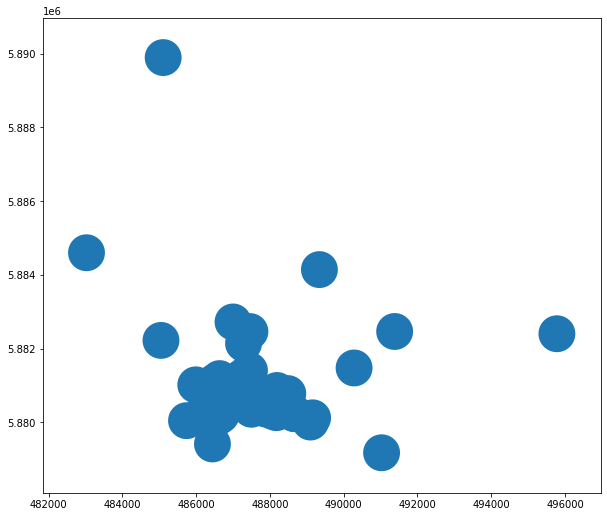

In [105]:
#making a dataframe of pubs csv and projecting to projected CRS & buffered by 500m
pubsdf = gpd.GeoDataFrame(
    pubs, geometry=gpd.points_from_xy(pubs.lng, pubs.lat),crs="EPSG:4326")
pubsdfproj = pubsdf.to_crs('EPSG:25832')
pubsdfproj['geometry'] = pubsdfproj.geometry.buffer(500)
pubsdfproj.plot(figsize=(10,10))

In [106]:
#display output
pubsdfproj

,lat,lng,name,address,geometry
0,53.072943,8.822785,Heldenbar,Ostertorsteinweg 105,"POLYGON ((488627.062 5880399.617, 488624.654 5..."
1,53.073407,8.824390,Fehrfeld,Fehrfeld 58,"POLYGON ((488734.741 5880450.886, 488732.333 5..."
2,53.072847,8.822155,Wohnzimmer,Ostertorsteinweg 99,"POLYGON ((488584.844 5880389.011, 488582.436 5..."
3,53.069684,8.787122,Mono,Langemarckstraße 207,"POLYGON ((486236.697 5880043.488, 486234.289 5..."
4,53.072778,8.820219,Litfass,Ostertorsteinweg 22,"POLYGON ((488455.161 5880381.664, 488452.753 5..."
...,...,...,...,...,...
61,53.069980,8.837551,Hopfen & Schmalz,Hamburger Straße,"POLYGON ((489615.658 5880067.619, 489613.250 5..."
62,53.076447,8.812085,Craft Bier Bar,Am Wall 175,"POLYGON ((487911.229 5880791.167, 487908.822 5..."
63,53.071071,8.801042,Efendy Shisha Lounge,NaN,"POLYGON ((487169.796 5880195.131, 487167.388 5..."
64,53.075926,8.807232,John Benton,Am Markt 1,"POLYGON ((487585.984 5880734.098, 487583.576 5..."


In [107]:
#joining the FCD, ACC & Pubs data based on points they intersect 
pubsacc = gpd.sjoin(ovrspd_acc,pubsdfproj, op='intersects')
pubsacc.groupby(pubsacc['track.id']).count()

,lat_left,lng_left,speed,spddiff,geometry,spdlimit,year_left,month_left,ovrspd,index_right_1,...,hour,accident_category,longitude,latitude,day_of_week,index_right,lat_right,lng_right,name,address
track.id,,,,,,,,,,,,,,,,,,,,,
5e24ca2463c90936dc7b2ef6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5e24ca2663c90936dc7b34d8,240,240,240,240,240,240,240,240,240,240,...,240,240,240,240,240,240,240,240,240,240
5e31e60d63c90936dc3a7f74,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5e31e60e63c90936dc3a829d,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
5e31e60f63c90936dc3a887e,242,242,242,242,242,242,242,242,242,242,...,242,242,242,242,242,242,242,242,242,242
5e41f7ee3965f36894590e71,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
5e61052277e02d42aa97e73c,259,259,259,259,259,259,259,259,259,259,...,259,259,259,259,259,259,259,259,259,259
5e61052377e02d42aa97f262,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
5e61052577e02d42aa980743,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,...,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028


In [109]:
#displaying output on Map
lats1 = list(pubsacc['lat_left'])
lngs1 = list(pubsacc['lng_left'])
lt = list(pubs['lat'])
ln = list(pubs['lng'])
avg_lat = sum(lats1) / len(lats1)
avg_lngs = sum(lngs1) / len(lngs1)

m = folium.Map(location=[avg_lat, avg_lngs], tiles = 'cartodbpositron', zoom_start=10)
for lat, lng in zip(lats1,lngs1):
    folium.CircleMarker([lat, lng], radius=1).add_to(m)
for lat, lng in zip(lt,ln):
    folium.CircleMarker([lat, lng], radius=3, color = 'red').add_to(m)
m.save('overspeedingaccidentsnearpubs.html')